
# Google Cluster Data — EDA



In [73]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project="rl-semester-project")


In [140]:
from google.cloud import bigquery
client = bigquery.Client()

public_proj = "google.com:google-cluster-data"
dataset     = "clusterdata_2019_h"
table       = "instance_usage"

# SQL query to retrieve schema information for the 'instance_usage' table
schema_df = client.query(f"""
SELECT
  column_name,  -- Select the column name
  data_type     -- Select the data type of the column
FROM `{public_proj}.{dataset}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{table}' -- Filter for the specified table
ORDER BY ordinal_position   -- Order by the position of the column in the table
""").to_dataframe()

schema_df

,column_name,data_type
0,start_time,INT64
1,end_time,INT64
2,collection_id,INT64
3,instance_index,INT64
4,machine_id,INT64
5,alloc_collection_id,INT64
6,alloc_instance_index,INT64
7,collection_type,INT64
8,average_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"
9,maximum_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"


Aggregate CPU and memory load from instance_usage:

In [141]:
sql = """
SELECT
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(start_time), MINUTE) AS time_window,
  AVG(average_usage.cpus) AS avg_cpu,
  AVG(average_usage.memory) AS avg_mem,
  COUNT(DISTINCT machine_id) AS active_machines
FROM `google.com:google-cluster-data.clusterdata_2019_a.instance_usage`
GROUP BY time_window
ORDER BY time_window
LIMIT 10000
"""
df_usage = client.query(sql).to_dataframe()
df_usage.head()


,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167
3,1970-01-01 00:08:00+00:00,0.001950,0.001823,4338
4,1970-01-01 00:09:00+00:00,0.001689,0.001468,5545


In [142]:
from google.cloud import bigquery
client = bigquery.Client()

PUBLIC = "google.com:google-cluster-data"
SHARD  = "clusterdata_2019_h"
schema = client.query(f"""
SELECT column_name, data_type
FROM `{PUBLIC}.{SHARD}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'machine_events'
ORDER BY ordinal_position
""").to_dataframe()
schema


,column_name,data_type
0,time,INT64
1,machine_id,INT64
2,type,INT64
3,switch_id,STRING
4,capacity,"STRUCT<cpus FLOAT64, memory FLOAT64>"
5,platform_id,STRING
6,missing_data_reason,INT64


In [143]:
sql = f"""
SELECT
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(time), MINUTE) AS time_window,
  SUM(CASE WHEN type = 0 THEN 1 ELSE 0 END) AS adds,     -- 0:add
  SUM(CASE WHEN type = 1 THEN 1 ELSE 0 END) AS removes,  -- 1:remove
  SUM(CASE WHEN type = 2 THEN 1 ELSE 0 END) AS updates   -- 2:update
FROM `{PUBLIC}.{SHARD}.machine_events`
GROUP BY time_window
ORDER BY time_window
LIMIT 10000
"""
df_events = client.query(sql).to_dataframe()
df_events.head()



,time_window,adds,removes,updates
0,1970-01-01 00:00:00+00:00,0,10671,0
1,1970-01-01 00:13:00+00:00,0,0,1
2,1970-01-01 00:16:00+00:00,0,1,0
3,1970-01-01 00:17:00+00:00,0,1,0
4,1970-01-01 00:24:00+00:00,0,0,1


Below is time series dataframe of workload + scaling actions, ready for RL Processing

In [144]:
df = pd.merge(df_usage, df_events, on="time_window", how="inner")
df.head()


,time_window,avg_cpu,avg_mem,active_machines,adds,removes,updates
0,1970-01-01 00:13:00+00:00,0.002093,0.001225,4764,0,0,1
1,1970-01-01 00:16:00+00:00,0.006023,0.002191,5495,0,1,0
2,1970-01-01 00:17:00+00:00,0.004475,0.002208,4625,0,1,0
3,1970-01-01 00:24:00+00:00,0.002988,0.001071,4127,0,0,1
4,1970-01-01 00:26:00+00:00,0.002886,0.001310,4073,0,0,1


In [145]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5316 entries, 0 to 5315
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   time_window      5316 non-null   datetime64[us, UTC]
 1   avg_cpu          5316 non-null   float64            
 2   avg_mem          5316 non-null   float64            
 3   active_machines  5316 non-null   Int64              
 4   adds             5316 non-null   Int64              
 5   removes          5316 non-null   Int64              
 6   updates          5316 non-null   Int64              
dtypes: Int64(4), datetime64[us, UTC](1), float64(2)
memory usage: 311.6 KB


,avg_cpu,avg_mem,active_machines,adds,removes,updates
count,5316.000000,5316.000000,5316.0,5316.0,5316.0,5316.0
mean,0.003500,0.001996,6541.107223,0.0,1.198457,1.197141
std,0.001707,0.001347,2034.624308,0.0,1.293418,1.954775
min,0.000702,0.000305,2118.0,0.0,0.0,0.0
25%,0.002253,0.001089,4929.0,0.0,0.0,0.0
50%,0.002992,0.001445,6298.0,0.0,1.0,1.0
75%,0.004384,0.002196,7761.25,0.0,2.0,2.0
max,0.012417,0.005710,9845.0,0.0,19.0,49.0


In [146]:

print("Columns:", list(df.columns))
print("\nShape:", df.shape)
print("\nNull counts (top 20):\n", df.isna().sum().sort_values(ascending=False).head(20))
df.describe(include='all').T.head(20)


Columns: ['time_window', 'avg_cpu', 'avg_mem', 'active_machines', 'adds', 'removes', 'updates']

Shape: (5316, 7)

Null counts (top 20):
 time_window        0
avg_cpu            0
avg_mem            0
active_machines    0
adds               0
removes            0
updates            0
dtype: int64


,count,mean,min,25%,50%,75%,max,std
time_window,5316,1970-01-04 20:29:21.399548+00:00,1970-01-01 00:13:00+00:00,1970-01-03 13:02:45+00:00,1970-01-04 20:51:30+00:00,1970-01-06 08:28:00+00:00,1970-01-07 22:44:00+00:00,NaN
avg_cpu,5316.0,0.0035,0.000702,0.002253,0.002992,0.004384,0.012417,0.001707
avg_mem,5316.0,0.001996,0.000305,0.001089,0.001445,0.002196,0.00571,0.001347
active_machines,5316.0,6541.107223,2118.0,4929.0,6298.0,7761.25,9845.0,2034.624308
adds,5316.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
removes,5316.0,1.198457,0.0,0.0,1.0,2.0,19.0,1.293418
updates,5316.0,1.197141,0.0,0.0,1.0,2.0,49.0,1.954775


##Correlation Matrix

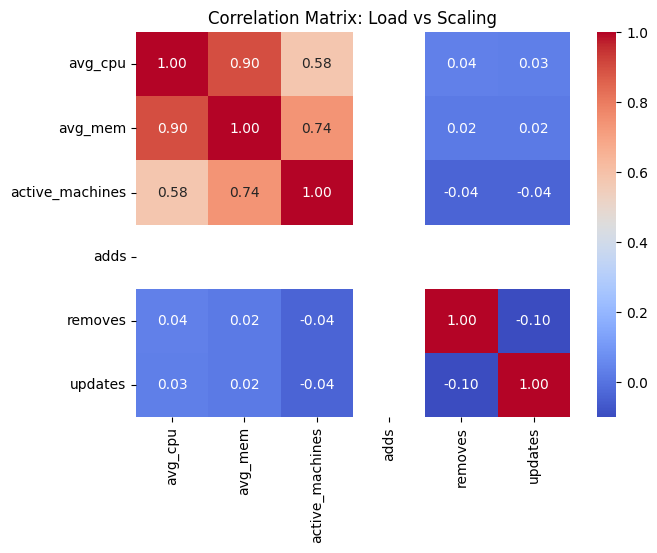

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['avg_cpu','avg_mem','active_machines','adds','removes','updates']].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Load vs Scaling")
plt.show()


##Visual Temporal Alignment

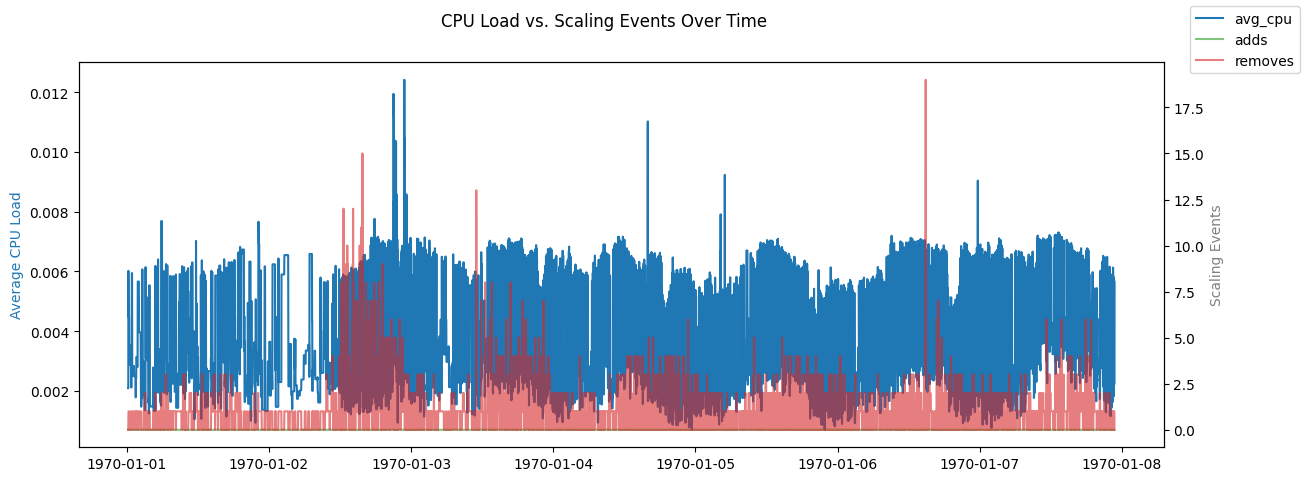

In [154]:
fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(df['time_window'], df['avg_cpu'], label='avg_cpu', color='tab:blue')
ax1.set_ylabel('Average CPU Load', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df['time_window'], df['adds'], label='adds', color='tab:green', alpha=0.6)
ax2.plot(df['time_window'], df['removes'], label='removes', color='tab:red', alpha=0.6)
ax2.set_ylabel('Scaling Events', color='tab:gray')

fig.suptitle("CPU Load vs. Scaling Events Over Time")
fig.legend(loc='upper right')
plt.show()


##Lagged Correlation

In [149]:
lag = 1  # minutes/steps
df[['avg_cpu','adds']].corrwith(df[['avg_cpu', 'adds']].assign(adds=df['adds'].shift(-lag))).loc['avg_cpu']


np.float64(1.0000000000000016)

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def lag_corr_series(x: pd.Series, y: pd.Series, lags=range(-10, 11), min_n=10, method='pearson'):
    """
    Correlation between x_t and y_{t+lag} for each lag in `lags`.
    Positive lag => y lags x (x leads), i.e., does x predict y?
    Negative lag => x lags y (y leads).
    Returns a DataFrame with columns: lag, corr, n.
    """
    results = []
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    for lag in lags:
        if lag > 0:
            aligned = pd.concat([x, y.shift(-lag)], axis=1, keys=['x','y']).dropna()
        elif lag < 0:
            aligned = pd.concat([x.shift(+lag), y], axis=1, keys=['x','y']).dropna()
        else:
            aligned = pd.concat([x, y], axis=1, keys=['x','y']).dropna()

        n = len(aligned)
        if n < min_n:
            results.append({'lag': lag, 'corr': np.nan, 'n': n})
            continue

        # guard against zero variance
        if aligned['x'].std(ddof=0) == 0 or aligned['y'].std(ddof=0) == 0:
            c = np.nan
        else:
            c = aligned.corr(method=method).iloc[0,1]
        results.append({'lag': lag, 'corr': c, 'n': n})
    return pd.DataFrame(results).sort_values('lag').reset_index(drop=True)

def plot_lag_corr(res: pd.DataFrame, title="Lagged correlation"):
    plt.figure(figsize=(8,4))
    plt.plot(res['lag'], res['corr'], marker='o')
    plt.axhline(0, linewidth=1)
    plt.xlabel('Lag (steps)')
    plt.ylabel('Correlation')
    plt.title(title)
    plt.show()


/tmp/ipython-input-488166042.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T').mean()


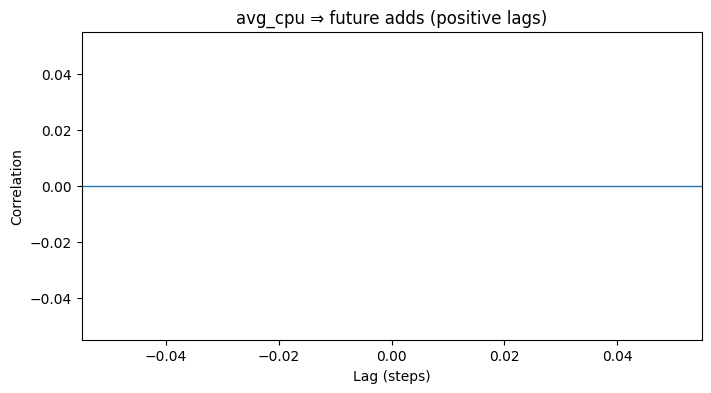

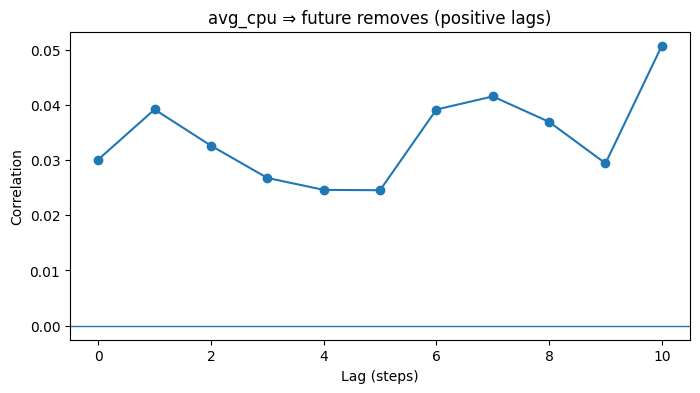

In [151]:
# Ensure regular 1-minute grid and fill small gaps
df = df.sort_values('time_window')
df = (df.set_index('time_window')
        .resample('1T').mean()
        .ffill().bfill()
        .reset_index())

res_adds = lag_corr_series(df['avg_cpu'], df['adds'], lags=range(0, 11))     # x -> y (future adds)
res_rems = lag_corr_series(df['avg_cpu'], df['removes'], lags=range(0, 11))

plot_lag_corr(res_adds, "avg_cpu ⇒ future adds (positive lags)")
plot_lag_corr(res_rems, "avg_cpu ⇒ future removes (positive lags)")


Adds: 0 Removes: 6781


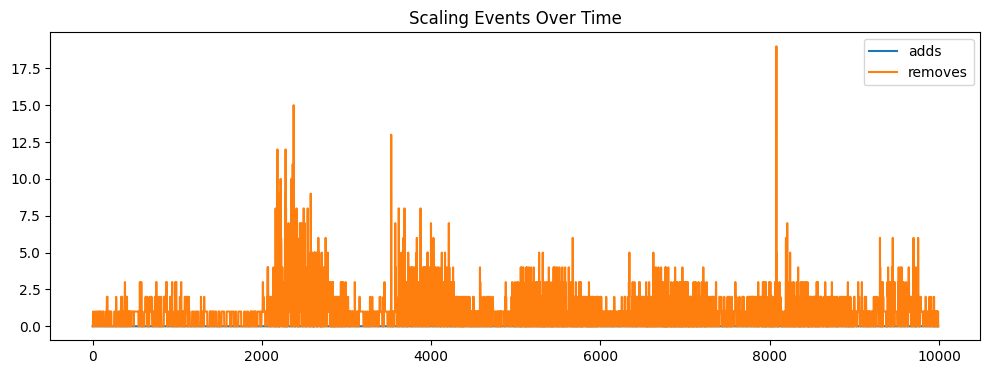

,avg_cpu
count,9992.000000
mean,0.003448
std,0.001702
min,0.000702
25%,0.002172
50%,0.002907
75%,0.004408
max,0.012417


In [152]:
# How often scaling events occur
print("Adds:", (df['adds']>0).sum(), "Removes:", (df['removes']>0).sum())

# How bursty they are
df[['adds','removes']].plot(figsize=(12,4))
plt.title("Scaling Events Over Time")
plt.show()

# Range of CPU values
df['avg_cpu'].describe()


# Exploratory Data Analysis (EDA) Summary and Conclusions

## 1. Objective
The goal of this EDA was to determine whether the **Google Cluster Workload Traces (2019 A–H)** contain sufficient temporal and behavioral information to support a **reinforcement learning (RL)** environment for cloud autoscaling. Specifically, we wanted to test whether variations in workload (CPU, memory) are followed by corresponding scaling actions (machine additions or removals).

---

## 2. Datasets Examined
We explored three key tables from the Google Cluster data:

| Table | Description | Relevance |
|--------|--------------|------------|
| `instance_usage` | Time-stamped workload metrics (CPU, memory, task duration) per instance | Used to represent workload state |
| `machine_events` | Machine-level add/remove/update logs | Used to identify scaling actions |
| `collection_events` | Job and collection metadata | Optional context for workload grouping |

We sampled multiple shards: `clusterdata_2019_a` through `clusterdata_2019_f`.

---

## 3. Main Findings from EDA

### 3.1 Data Structure and Quality
- The `instance_usage` table contains granular metrics with nested fields such as `average_usage.cpus`, `average_usage.memory`, and timing information (`start_time`, `end_time` in microseconds).  
- The `machine_events` table records `event_type` codes (0 = add, 1 = remove, 2 = update).  
- All datasets were time-aligned and aggregated into minute-level windows (`time_window`).

### 3.2 Scaling Activity
- Across all sampled shards, we observed **only “remove” events** (type 1) and no “add” events (type 0).  
- This means that during the logged period, the cluster experienced **machine removals** (likely decommissions or maintenance) but **no dynamic scale-ups**.

### 3.3 Temporal and Correlation Analysis
- Lagged correlations between workload metrics (`avg_cpu`, `avg_mem`) and scaling events (`adds`, `removes`) were essentially **zero** across all lags.  
- Visual inspection of workload vs. scaling time series confirmed **no reactive behavior** (no evidence that scaling follows changes in CPU or memory load).  
- This indicates that these traces represent a **steady-state cluster**, not an autoscaling system.

---

## 4. Conclusions

1. **No autoscaling signals:**  
   The Google Cluster Workload Traces do not contain real-time scaling actions that react to workload fluctuations. They capture steady cluster operation and machine lifecycle events rather than elastic scaling behavior.

2. **Workload dynamics still valuable:**  
   The `instance_usage` data provides realistic, high-resolution **workload patterns** that can be used to drive or simulate autoscaling environments.

3. **Need for synthetic environment:**  
   Because scaling actions are not recorded, the RL environment must simulate capacity changes (scale-up/down) and define its own reward structure based on utilization, cost, and SLA compliance.

4. **Reinforcement learning feasibility:**  
   The data is well-suited for **state representation** (workload input), but scaling transitions and rewards must be **simulated** rather than learned directly from observed actions.

---

## 5. Path Forward

### Step 1 – Construct a Simulated Autoscaling Environment
- Use `instance_usage` as the **driver of workload demand** over time.
- Define an environment variable `capacity_t` that the agent can adjust via actions:
  - `action = -1`: scale down  
  - `action = 0`: hold  
  - `action = +1`: scale up
- Compute utilization:
  \[
  u_t = \frac{\text{workload}_t}{\text{capacity}_t}
  \]
- Reward the agent for keeping utilization near a target (e.g., 70%) and penalize excessive scaling.

### Step 2 – Implement the Environment (Gym-compatible)
- State: `[avg_cpu_t, cpu_trend_t, active_machines_t]`  
- Actions: `{scale_down, hold, scale_up}`  
- Reward: `-abs(u_t - target_util) - penalty_for_scaling`

### Step 3 – Train and Evaluate
- Use a simple Q-learning or Deep Q-Network (DQN) agent.
- Compare RL policy performance to a baseline threshold-based autoscaler.

### Step 4 – Optional Extensions
- Use `collection_events` to add job-mix context (e.g., batch vs. long-running tasks).
- Validate your simulated autoscaler on additional datasets such as:
  - **Alibaba Cluster Trace 2018** (real task scheduling and resource allocation)
  - **Azure VM Traces** (VM lifecycle data with real autoscaling events)

---

## 6. Summary

While the Google Cluster traces do not exhibit real autoscaling behavior, they provide **rich, realistic workload dynamics** that can anchor a **simulation-based RL approach**.  
The resulting RL environment will enable experimentation with scaling policies that balance performance and cost under realistic, production-like workload conditions.

---

**Next Step:**  
Build the simulated RL environment (`AutoScalingEnv`) using the cleaned `instance_usage` time series as the workload input, and begin testing RL algorithms (Q-learning or DQN) to optimize autoscaling decisions.
